---
title:  "CatBoost Practice 01"  
excerpt: "CatBoost, Ensemble, Gradient Descent"  

categories:  
  - Machine-Learning  
tags:  
  - Stacking  
  - Ensemble  
  - Medium  
  - Kaggle
last_modified_at: 2020-06-14T15:00:00-05:00
---

## Reference  
- [Medium Daniel Chepenko](https://towardsdatascience.com/introduction-to-gradient-boosting-on-decision-trees-with-catboost-d511a9ccbd14)
- 상기 Blog 역자의 Collab 코드
>  Kaggle competition 에 있는 data를 활용한다. 
>> 보험회사에 공개한, 심각한 회사차원의 보험손실 여부를 추정한 regression 모델

In [7]:
import pandas as pd

df_train = pd.read_csv('../dataset/allstate-claims-severity/train.csv')
df_test = pd.read_csv('../dataset/allstate-claims-severity/test.csv')

In [19]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set() # setting seaborn default for plots

In [8]:
print(df_train.shape) ## loss 값 있고,
print(df_test.shape)  ## loss 값 없음.

(188318, 132)
(125546, 131)


In [9]:
df_train.head()

,id,cat1,cat2,cat3,cat4,cat5,cat6,cat7,cat8,cat9,...,cont6,cont7,cont8,cont9,cont10,cont11,cont12,cont13,cont14,loss
0,1,A,B,A,B,A,A,A,A,B,...,0.718367,0.335060,0.30260,0.67135,0.83510,0.569745,0.594646,0.822493,0.714843,2213.18
1,2,A,B,A,A,A,A,A,A,B,...,0.438917,0.436585,0.60087,0.35127,0.43919,0.338312,0.366307,0.611431,0.304496,1283.60
2,5,A,B,A,A,B,A,A,A,B,...,0.289648,0.315545,0.27320,0.26076,0.32446,0.381398,0.373424,0.195709,0.774425,3005.09
3,10,B,B,A,B,A,A,A,A,B,...,0.440945,0.391128,0.31796,0.32128,0.44467,0.327915,0.321570,0.605077,0.602642,939.85
4,11,A,B,A,B,A,A,A,A,B,...,0.178193,0.247408,0.24564,0.22089,0.21230,0.204687,0.202213,0.246011,0.432606,2763.85


In [10]:
df_test.head(2)

,id,cat1,cat2,cat3,cat4,cat5,cat6,cat7,cat8,cat9,...,cont5,cont6,cont7,cont8,cont9,cont10,cont11,cont12,cont13,cont14
0,4,A,B,A,A,A,A,A,A,B,...,0.281143,0.466591,0.317681,0.61229,0.34365,0.38016,0.377724,0.369858,0.704052,0.392562
1,6,A,B,A,B,A,A,A,A,B,...,0.836443,0.482425,0.443760,0.71330,0.51890,0.60401,0.689039,0.675759,0.453468,0.208045


In [11]:
print("Number of missing values in train",df_train.isnull().sum().sum())
print("Number of missing values in test",df_test.isnull().sum().sum())

Number of missing values in train 0
Number of missing values in test 0


* 한꺼번에 전처리 하기 위해 묶은다음에 수행한다.

In [12]:
df_train_idx = df_train.index
df_test_idx = df_test.index
df_train['isTrain'] = True
df_test['isTrain'] = False
traintest = pd.concat([df_train, df_test], axis = 0)

In [29]:
set(df_train.columns)-set(df_test.columns)

{'loss'}

In [33]:
print(traintest.shape) ## 왜 133 이 되었지? -> isTrain 컬럼이 추가됨

(313864, 133)


* 컬럼이름 정리

In [13]:
import re
cat_pattern = re.compile("^cat([1-9]|[1-9][0-9]|[1-9][0-9][0-9])$")
cont_pattern = re.compile("^cont([1-9]|[1-9][0-9]|[1-9][0-9][0-9])$")

cat_col = sorted([cat for cat in traintest.columns if 'cat' in cat], key = lambda s: int(s[3:]))
cat_index = [i for i in range(0,len(traintest.columns)-1) if cat_pattern.match(traintest.columns[i])]
cont_col = sorted([cont for cont in traintest.columns if 'cont' in cont], key = lambda s: int(s[4:]))
cont_index = [i for i in range(0,len(traintest.columns)-1) if cont_pattern.match(traintest.columns[i])]
features = cat_col + cont_col

In [24]:
print(len(features)) ## 3개가 줄음 : isTrain,loss,id 컬럼
feats_counts = traintest[cat_col].nunique(dropna = False)

130


[datafram.nunique](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.nunique.html)

In [34]:
len(cat_col),len(cont_col)

(116, 14)

In [35]:
feats_counts.sort_values() ## 대략 categorical 컬럼의 cardinality 를 확인하기 위해 자주 사용한다.

cat1        2
cat52       2
cat51       2
cat50       2
cat49       2
         ... 
cat112     51
cat113     63
cat109     85
cat110    134
cat116    349
Length: 116, dtype: int64

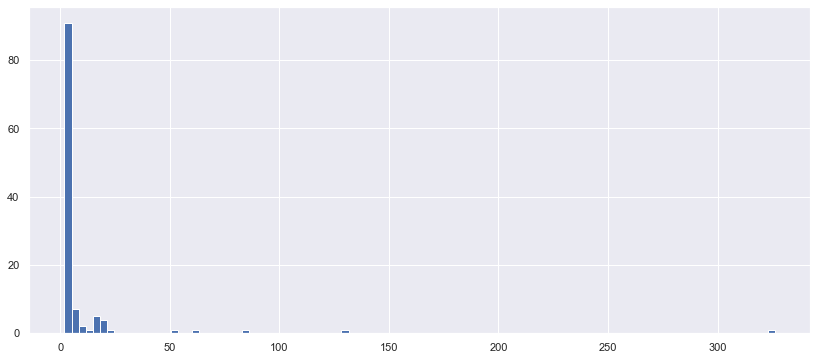

In [20]:
nunique = df_train[cat_col].nunique(dropna = False)
plt.figure(figsize=(14,6))
_ = plt.hist(nunique, bins=100)

대부분의 cardinality가 10 개 이하의, 2개 짜리의 컬럼이 매우 많고. cardinality 300 이 넘는 것도 있다.

In [37]:
mask = (nunique > 100) ## cardinality 100 개 넘는 것 찾기
df_train[cat_col].loc[:, mask]

,cat110,cat116
0,BC,LB
1,CQ,DP
2,DK,GK
3,CS,DJ
4,C,CK
...,...,...
188313,EG,CK
188314,BT,DF
188315,DM,DJ
188316,AI,MD


상기 같이 cardinality 높은 컬럼들은 뉴메릭으로 변환하거나, zero variance groups 으로 이니 제거하는게 나을 수 있다.

In [43]:
## cat110 컬럼에 대해 각 분류값별로, 얼마나 row 가 있는지 확인함
## df_train.groupby('cat110')['id'].size().sort_values() 과 동일
cat110_nunique = df_train.groupby('cat110')['id'].nunique().sort_values() 

In [44]:
# df_train.groupby('cat110')['id'].size().sort_values() 

In [40]:
cat110_nunique

cat110
BK        1
EH        1
BI        1
BD        1
DV        1
      ...  
CO    17495
EB    21396
CS    24592
EG    24654
CL    25305
Name: id, Length: 131, dtype: int64

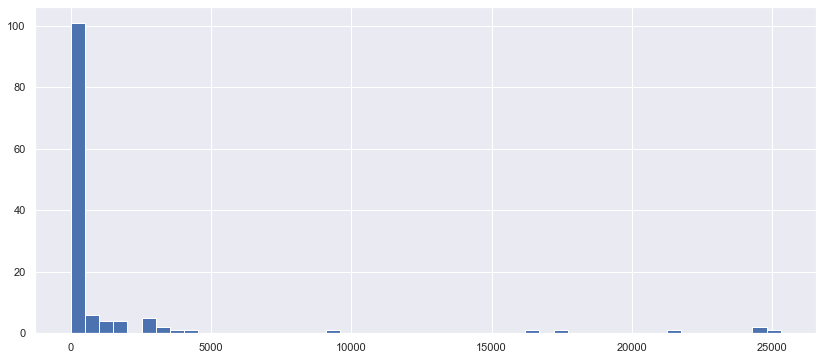

In [39]:
plt.figure(figsize=(14,6))
_ = plt.hist(cat110_nunique, bins=50)

대부분 1~2개씩 있는 것으로 보인다.

In [45]:
cat116_nunique = df_train.groupby('cat116')['id'].nunique().sort_values()

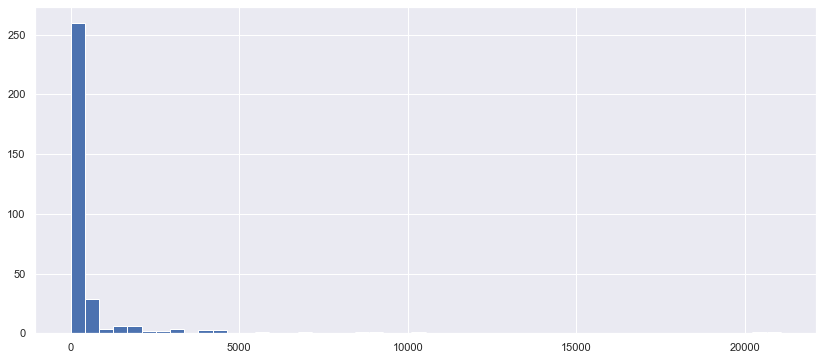

In [46]:
plt.figure(figsize=(14,6))
_ = plt.hist(cat116_nunique, bins=50)

The values are not float, they are integer, so these features are likely to be even counts. Let's look at another pack of features.

In [62]:
from tqdm.notebook import tqdm

In [58]:
## 예시
print(len(set(traintest['cat116'].factorize()[0])))

349


In [63]:
#Encoding categorical features to find duplicates
train_enc =  pd.DataFrame(index = traintest.index)

## categorical = cat_col 에 대해서, 모두 숫자화로 변형시킨다.
for col in tqdm(traintest[cat_col].columns):
    train_enc[col] = traintest[col].factorize()[0]

In [70]:
dup_cols = {} ## 중복되는 컬럼을 제거하는 과정
import numpy as np

for i, c1 in enumerate(tqdm(train_enc.columns)):
    for c2 in train_enc.columns[i + 1:]: ## i번째 컬럼이후 다른 모든 컬럼
        if c2 not in dup_cols and np.all(train_enc[c1] == train_enc[c2]):
            dup_cols[c2] = c1

In [71]:
dup_cols

{}

In [5]:
from catboost import CatBoostRegressor as cbr